In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from datetime import datetime
from tsgen import TsGenerator
from outsourcing import GDALBridge
import tif_explorer

In [39]:
### ENVIRONMENT SETUP

# Creating a list of iCOR .tiff files
raw_icor = os.listdir("D:\\L1_EFR_iCOR")
icor = [f for f in raw_icor if f.endswith('.tif')]
icor = [f.split('_processed.')[0] for f in icor]
# icor = [os.path.join("D:\\L1_EFR_iCOR",i) for i in icor]

# Creating a list of .shp files
areas_path = 'D:\\A1_JM\\areas'
areas = os.listdir(areas_path)
areas = [os.path.join(areas_path,a) for a in areas if a.endswith('.shp')]

# Creating a list of L2_WFR files
raw_wfr = os.listdir("E:\\S3\\L2_WFR")
wfr = [f.split('.')[0] for f in raw_wfr]

In [40]:
areas

['D:\\A1_JM\\areas\\coari.shp',
 'D:\\A1_JM\\areas\\fonte_boa.shp',
 'D:\\A1_JM\\areas\\madeira.shp',
 'D:\\A1_JM\\areas\\manacapuru.shp',
 'D:\\A1_JM\\areas\\negro.shp',
 'D:\\A1_JM\\areas\\tefe.shp']

In [41]:
print(len(icor))
icor[0:5]

319


['S3A_OL_1_EFR____20181002T140841_20181002T141141_20181003T182144_0179_036_224_3060_LN1_O_NT_002',
 'S3A_OL_1_EFR____20181003T134231_20181003T134531_20181004T174309_0179_036_238_3060_LN1_O_NT_002',
 'S3A_OL_1_EFR____20181006T140457_20181006T140757_20181007T190525_0179_036_281_3060_LN1_O_NT_002',
 'S3A_OL_1_EFR____20181007T133847_20181007T134147_20181008T182736_0179_036_295_3060_LN1_O_NT_002',
 'S3A_OL_1_EFR____20181010T140113_20181010T140413_20181011T180552_0179_036_338_3060_LN1_O_NT_002']

In [42]:
print(len(wfr))
wfr[0:5]

392


['S3A_OL_2_WFR____20190309T141223_20190309T141523_20190310T211622_0179_042_167_3060_MAR_O_NT_002',
 'S3A_OL_2_WFR____20190310T134612_20190310T134912_20190311T222357_0180_042_181_3060_MAR_O_NT_002',
 'S3A_OL_2_WFR____20190313T140838_20190313T141138_20190314T214804_0179_042_224_3060_MAR_O_NT_002',
 'S3A_OL_2_WFR____20190314T134227_20190314T134527_20190315T222121_0179_042_238_3060_MAR_O_NT_002',
 'S3A_OL_2_WFR____20190317T140455_20190317T140755_20190318T205900_0179_042_281_3060_MAR_O_NT_002']

In [43]:
# Now we neet to check for the matching dates.
set_icor = set([i[16:31] for i in icor])
set_wfr = set([w[16:31] for w in wfr])
matches = set_icor.intersection(set_wfr)
print(len(matches))
matches

204


{'20190309T141223',
 '20190310T134612',
 '20190313T140838',
 '20190314T134227',
 '20190317T140455',
 '20190318T133844',
 '20190319T141408',
 '20190320T134757',
 '20190321T140111',
 '20190322T133501',
 '20190323T141024',
 '20190324T134413',
 '20190325T135728',
 '20190326T133117',
 '20190327T140640',
 '20190328T134029',
 '20190331T140256',
 '20190401T133645',
 '20190402T135001',
 '20190403T132350',
 '20190404T135911',
 '20190405T133300',
 '20190405T141228',
 '20190406T134617',
 '20190408T135527',
 '20190409T140844',
 '20190410T134233',
 '20190412T135143',
 '20190413T132532',
 '20190413T140500',
 '20190414T133849',
 '20190415T141409',
 '20190416T134758',
 '20190417T140116',
 '20190418T133506',
 '20190419T141025',
 '20190420T134414',
 '20190421T135732',
 '20190422T133122',
 '20190423T140640',
 '20190424T134029',
 '20190425T135348',
 '20190426T132738',
 '20190427T140255',
 '20190428T133644',
 '20190429T135004',
 '20190430T132354',
 '20190501T135911',
 '20190502T133300',
 '20190502T141231',


In [44]:
valid_icor = [i for i in icor if i[16:31] in matches]

In [45]:
print(f'Before:{len(icor)} -> After:{len(valid_icor)}')

Before:319 -> After:204


In [46]:
valid_wfr = [w for w in wfr if w[16:31] in matches]

In [47]:
print(f'Before:{len(wfr)} -> After:{len(valid_wfr)}')

Before:392 -> After:204


In [48]:
# We have the matching files list, now we can actually load the data inside these files.
icor_files = [os.path.join("D:\\L1_EFR_iCOR",s+"_processed.tif") for s in valid_icor]

In [49]:
# iCOR zonal stats for each area
t1 = time.perf_counter()

# bs: band statistics
coari_bs_icor = [run.tif_stats(areas[0], img) for img in icor_files]
fonte_boa_bs_icor = [run.tif_stats(areas[1], img) for img in icor_files]
madeira_bs_icor = [run.tif_stats(areas[2], img) for img in icor_files]
manacapuru_bs_icor = [run.tif_stats(areas[3], img) for img in icor_files]
negro_bs_icor = [run.tif_stats(areas[4], img) for img in icor_files]
tefe_bs_icor = [run.tif_stats(areas[5], img) for img in icor_files]

t2 = time.perf_counter()
print(f'Finished in {round(t2 - t1, 2)} second(s).')

Finished in 222.7 second(s).


## iCOR DataFrames

In [52]:
df_coari_icor = pd.DataFrame(coari_bs_icor)
df_fonte_boa_icor = pd.DataFrame(fonte_boa_bs_icor)
df_madeira_icor = pd.DataFrame(madeira_bs_icor)
df_manaca_icor = pd.DataFrame(manacapuru_bs_icor)
df_negro_icor = pd.DataFrame(negro_bs_icor)
df_tefe_icor = pd.DataFrame(tefe_bs_icor)

In [259]:
# Saving the DFs to files
# IMPORTANT: Files not present in the matching list where left out of this DFs
t1 = time.perf_counter()

df_coari_icor.to_csv("D:\\processing\\win\\coari_icor_ts_match.csv")
df_fonte_boa_icor.to_csv("D:\\processing\\win\\fonte_boa_icor_ts_match.csv")
df_madeira_icor.to_csv("D:\\processing\\win\\madeira_icor_ts_match.csv")
df_manaca_icor.to_csv("D:\\processing\\win\\manacapuru_icor_ts_match.csv")
df_negro_icor.to_csv("D:\\processing\\win\\negro_icor_ts_match.csv")
df_tefe_icor.to_csv("D:\\processing\\win\\tefe_icor_ts_match.csv")

t2 = time.perf_counter()
print(f'Finished in {round(t2 - t1, 2)} second(s).')

Finished in 0.04 second(s).


In [83]:
df_coari_icor.sort_values('Datetime')

,Datetime,Date-String,B1-400,B2-412.5,B3-442.5,B4-490,B5-510,B6-560,B7-620,B8-665,B9-673.75,B10-681.25,B11-708.75,B12-753.75,B16-778.75,B17-865,B18-885,B21-1020,filename
0,2019-03-09 14:12:23,20190309T141223,0.031364,0.027139,0.042433,0.059421,0.066714,0.094745,0.118679,0.125730,0.127722,0.128632,0.110981,0.050497,0.053426,0.031043,0.025938,0.007191,S3A_OL_1_EFR____20190309T141223_20190309T14152...
1,2019-03-10 13:46:12,20190310T134612,-0.101365,-0.106381,-0.100553,-0.081256,-0.068869,-0.033343,-0.009228,0.001457,0.004376,0.006690,0.008478,-0.010702,-0.001677,-0.006883,-0.008276,-0.009600,S3A_OL_1_EFR____20190310T134612_20190310T13491...
2,2019-03-13 14:08:38,20190313T140838,0.153889,0.147547,0.155781,0.165427,0.172391,0.191405,0.204163,0.207684,0.208356,0.209981,0.225030,0.214829,0.221886,0.217280,0.217994,0.197501,S3A_OL_1_EFR____20190313T140838_20190313T14113...
3,2019-03-14 13:42:27,20190314T134227,0.081792,0.076867,0.083632,0.096864,0.107769,0.132013,0.147159,0.153539,0.154766,0.157252,0.188569,0.198835,0.210264,0.220207,0.224416,0.216451,S3A_OL_1_EFR____20190314T134227_20190314T13452...
4,2019-03-17 14:04:55,20190317T140455,0.082925,0.076825,0.085074,0.096106,0.102617,0.124114,0.141074,0.145981,0.147227,0.148288,0.150685,0.119963,0.126179,0.118476,0.117807,0.104475,S3A_OL_1_EFR____20190317T140455_20190317T14075...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2019-09-26 14:01:15,20190926T140115,0.037774,0.036137,0.043646,0.057551,0.066033,0.094910,0.112113,0.112681,0.113092,0.113837,0.102803,0.059010,0.064511,0.052484,0.050219,0.041350,S3A_OL_1_EFR____20190926T140115_20190926T14041...
102,2019-09-27 13:35:04,20190927T133504,0.615269,0.607728,0.611822,0.633257,0.644733,0.671693,0.687971,0.665603,0.690734,0.692433,0.764381,0.731618,0.702671,0.678230,0.754012,0.658621,S3A_OL_1_EFR____20190927T133504_20190927T13380...
202,2019-09-28 14:10:18,20190928T141018,0.189448,0.184058,0.188452,0.195630,0.201506,0.218365,0.225367,0.225926,0.225532,0.226347,0.242707,0.244564,0.251575,0.254837,0.257464,0.263370,S3B_OL_1_EFR____20190928T141018_20190928T14131...
203,2019-09-29 13:44:07,20190929T134407,0.013760,0.004272,0.007389,0.021143,0.031033,0.063109,0.075366,0.075958,0.076166,0.077246,0.090534,0.101082,0.111603,0.117460,0.119509,0.133637,S3B_OL_1_EFR____20190929T134407_20190929T13470...


## Reading WFR DataFrames (disregarding matches)

In [260]:
# Loading WFR dataframes
workdir = "D:\\processing\\win"

ts_list = ["coari_wfr_ts.csv",
          "fonte_boa_wfr_ts.csv",
          "madeira_wfr_ts.csv",
          "manacapuru_wfr_ts.csv",
          "negro_wfr_ts.csv",
          "tefe_wfr_ts.csv"]

df_coari_wfr = pd.read_csv(os.path.join(workdir,ts_list[0]), parse_dates=['Datetime'])
df_fonte_boa_wfr = pd.read_csv(os.path.join(workdir,ts_list[1]), parse_dates=['Datetime'])
df_madeira_wfr = pd.read_csv(os.path.join(workdir,ts_list[2]), parse_dates=['Datetime'])
df_manacapuru_wfr = pd.read_csv(os.path.join(workdir,ts_list[3]), parse_dates=['Datetime'])
df_negro_wfr = pd.read_csv(os.path.join(workdir,ts_list[4]), parse_dates=['Datetime'])
df_tefe_wfr = pd.read_csv(os.path.join(workdir,ts_list[5]), parse_dates=['Datetime'])

In [163]:
# Now we need to compatibilize the WFR dataset sizes to hold only the matching dates
print('Total WFR DataFrame len:',len(df_coari_wfr))
print('Elements that match the dates:',len(df_coari_wfr[df_coari_wfr['Date-String'].isin(matches)]))
print('no-match:',len(df_coari_wfr[~df_coari_wfr['Date-String'].isin(matches)]))

df_coari_wfr_match = df_coari_wfr[df_coari_wfr['Date-String'].isin(matches)]
df_coari_wfr_nomat = df_coari_wfr[~df_coari_wfr['Date-String'].isin(matches)]

df_coari_icor_match = df_coari_icor[df_coari_icor['Date-String'].isin(df_coari_wfr_match['Date-String'])]
df_coari_icor_nomat = df_coari_icor[~df_coari_icor['Date-String'].isin(df_coari_wfr_match['Date-String'])]

print('\nTotal iCOR DataFrame len:',len(df_coari_icor))
print('Elements that match the dates:',len(df_coari_icor[df_coari_icor['Date-String'].isin(df_coari_wfr_match['Date-String'])]))
print('no-match:',len(df_coari_icor[~df_coari_icor['Date-String'].isin(df_coari_wfr_match['Date-String'])]))

print('\nNO-MATCH:')
df_coari_icor_nomat

Total WFR DataFrame len: 311
Elements that match the dates: 154
no-match: 157

Total iCOR DataFrame len: 204
Elements that match the dates: 154
no-match: 50

NO-MATCH:


,Datetime,Date-String,B1-400,B2-412.5,B3-442.5,B4-490,B5-510,B6-560,B7-620,B8-665,B9-673.75,B10-681.25,B11-708.75,B12-753.75,B16-778.75,B17-865,B18-885,B21-1020,filename
1,2019-03-10 13:46:12,20190310T134612,-0.101365,-0.106381,-0.100553,-0.081256,-0.068869,-0.033343,-0.009228,0.001457,0.004376,0.006690,0.008478,-0.010702,-0.001677,-0.006883,-0.008276,-9.600326e-03,S3A_OL_1_EFR____20190310T134612_20190310T13491...
3,2019-03-14 13:42:27,20190314T134227,0.081792,0.076867,0.083632,0.096864,0.107769,0.132013,0.147159,0.153539,0.154766,0.157252,0.188569,0.198835,0.210264,0.220207,0.224416,2.164514e-01,S3A_OL_1_EFR____20190314T134227_20190314T13452...
11,2019-04-03 13:23:50,20190403T132350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,S3A_OL_1_EFR____20190403T132350_20190403T13265...
12,2019-04-05 14:12:28,20190405T141228,0.036446,0.028710,0.043288,0.060615,0.067514,0.095322,0.121870,0.129791,0.132139,0.132855,0.107787,0.036158,0.039404,0.023332,0.019614,1.199535e-02,S3A_OL_1_EFR____20190405T141228_20190405T14152...
13,2019-04-06 13:46:17,20190406T134617,-0.000379,-0.005990,-0.002166,0.011598,0.021209,0.047867,0.068700,0.075760,0.078179,0.079801,0.073009,0.036755,0.043251,0.033827,0.031790,2.589539e-02,S3A_OL_1_EFR____20190406T134617_20190406T13491...
14,2019-04-09 14:08:44,20190409T140844,0.353751,0.341812,0.344106,0.346099,0.351526,0.361221,0.368975,0.371574,0.371611,0.373725,0.406338,0.400059,0.406739,0.408268,0.412789,3.868431e-01,S3A_OL_1_EFR____20190409T140844_20190409T14114...
15,2019-04-10 13:42:33,20190410T134233,0.509031,0.502213,0.503085,0.504317,0.512234,0.517229,0.521174,0.522012,0.521470,0.523950,0.576396,0.565762,0.573169,0.579355,0.586511,5.481341e-01,S3A_OL_1_EFR____20190410T134233_20190410T13453...
16,2019-04-13 14:05:00,20190413T140500,0.022421,0.017619,0.024732,0.036393,0.042777,0.067291,0.086179,0.091659,0.093350,0.094023,0.079905,0.031155,0.034598,0.017963,0.014440,4.886167e-03,S3A_OL_1_EFR____20190413T140500_20190413T14080...
17,2019-04-14 13:38:49,20190414T133849,0.045264,0.039825,0.047170,0.059556,0.067344,0.091546,0.108047,0.112625,0.113958,0.114943,0.116290,0.091229,0.096987,0.088342,0.086870,7.957168e-02,S3A_OL_1_EFR____20190414T133849_20190414T13414...
18,2019-04-17 14:01:16,20190417T140116,0.012179,0.011553,0.020806,0.035514,0.043015,0.066765,0.086055,0.092096,0.093616,0.094701,0.085847,0.045174,0.050146,0.042223,0.041072,3.587031e-02,S3A_OL_1_EFR____20190417T140116_20190417T14041...


In [208]:
# Turning the compatibility match into a function

def dfcompat(df1, df2, colname):
    """
    Compare two pd.DataFrames given a common column in both of them,
    then, return two new DFs containing only the rows where they mach in
    the given column and the set used to match them.
    """
    set_df1 = set(df1[colname])
    set_df2 = set(df2[colname])
    matches = set_df1.intersection(set_df2)
    
    df1_match = df1[df1[colname].isin(matches)]
    df2_match = df2[df2[colname].isin(matches)]
    
    return df1_match, df2_match, matches

## Generate matching DataFrames for the WFR files

In [304]:
# NOTE: The iCOR DataFrames where already generated using only the 
# matching dates. We will just match iCOR here for the sake of example.
t1 = time.perf_counter()

df_coari_wfr_m2, df_coari_icor_m2, coari_m = dfcompat(df_coari_wfr_m, df_coari_icor_m, 'Date-String')
df_fonte_boa_wfr_m2, df_fonte_boa_icor_m2, fonte_boa_m  = dfcompat(df_fonte_boa_wfr_m,df_fonte_boa_icor_m, 'Date-String')
df_madeira_wfr_m2, df_madeira_icor_m2, madeira_m = dfcompat(df_madeira_wfr_m,df_madeira_icor_m, 'Date-String')
df_manaca_wfr_m2, df_manaca_icor_m2, manaca_m = dfcompat(df_manacapuru_wfr_m,df_manaca_icor_m, 'Date-String')
df_negro_wfr_m2, df_negro_icor_m2, negro_m = dfcompat(df_negro_wfr_m,df_negro_icor_m, 'Date-String')
df_tefe_wfr_m2, df_tefe_icor_m2, tefe_m = dfcompat(df_tefe_wfr_m,df_tefe_icor_m, 'Date-String')

t2 = time.perf_counter()
print(f'Finished in {round(t2 - t1, 2)} second(s).')

Finished in 0.01 second(s).


In [305]:
# Test if the matching have worked
print(len(df_coari_icor_m2),
      len(df_fonte_boa_icor_m2),
      len(df_madeira_icor_m2),
      len(df_manaca_icor_m2),
      len(df_negro_icor_m2),
      len(df_tefe_icor_m2))

print(len(df_coari_wfr_m2),
      len(df_fonte_boa_wfr_m2),
      len(df_madeira_wfr_m2),
      len(df_manaca_wfr_m2),
      len(df_negro_wfr_m2),
      len(df_tefe_wfr_m2))

154 129 152 183 188 160
154 129 152 183 188 160


## Saving WFR matched DataFrames to CSV

In [250]:
df_coari_wfr_m.to_csv("D:\\processing\\win\\coari_wfr_ts_match.csv")
df_fonte_boa_wfr_m.to_csv("D:\\processing\\win\\fonte_boa_wfr_ts_match.csv")
df_madeira_wfr_m.to_csv("D:\\processing\\win\\madeira_wfr_ts_match.csv")
df_manacapuru_wfr_m.to_csv("D:\\processing\\win\\manacapuru_wfr_ts_match.csv")
df_negro_wfr_m.to_csv("D:\\processing\\win\\negro_wfr_ts_match.csv")
df_tefe_wfr_m.to_csv("D:\\processing\\win\\tefe_wfr_ts_match.csv")

In [119]:
print('icor match len:',len(df_coari_icor_match))
print('icor Oa08 <= 0.2:',len(df_coari_icor_match[df_coari_icor_match['B8-665'] <= 0.2]))
print('icor Oa08 >= 0.2:',len(df_coari_icor_match[df_coari_icor_match['B8-665'] >= 0.2]))
print('')
print('wfr match len:',len(df_coari_wfr_match))
print('wfr Oa08 <= 0.2:',len(df_coari_wfr_match[df_coari_wfr_match['B8-665'] <= 0.2]))
print('wfr Oa08 >= 0.2:',len(df_coari_wfr_match[df_coari_wfr_match['B8-665'] >= 0.2]))

icor match len: 178
icor Oa08 <= 0.2: 103
icor Oa08 >= 0.2: 75

wfr match len: 178
wfr Oa08 <= 0.2: 136
wfr Oa08 >= 0.2: 0


## PART II: Re-loading the iCOR and WFR DataFrames so they can be sorted by date

In [297]:
df_coari_icor_m = pd.read_csv("D:\\processing\\win\\coari_icor_ts_match.csv", parse_dates=['Datetime'])
df_fonte_boa_icor_m = pd.read_csv("D:\\processing\\win\\fonte_boa_icor_ts_match.csv", parse_dates=['Datetime'])
df_madeira_icor_m = pd.read_csv("D:\\processing\\win\\madeira_icor_ts_match.csv", parse_dates=['Datetime'])
df_manaca_icor_m = pd.read_csv("D:\\processing\\win\\manacapuru_icor_ts_match.csv", parse_dates=['Datetime'])
df_negro_icor_m = pd.read_csv("D:\\processing\\win\\negro_icor_ts_match.csv", parse_dates=['Datetime'])
df_tefe_icor_m = pd.read_csv("D:\\processing\\win\\tefe_icor_ts_match.csv", parse_dates=['Datetime'])

df_coari_wfr_m = pd.read_csv("D:\\processing\\win\\coari_wfr_ts_match.csv", parse_dates=['Datetime'])
df_fonte_boa_wfr_m = pd.read_csv("D:\\processing\\win\\fonte_boa_wfr_ts_match.csv", parse_dates=['Datetime'])
df_madeira_wfr_m = pd.read_csv("D:\\processing\\win\\madeira_wfr_ts_match.csv", parse_dates=['Datetime'])
df_manaca_wfr_m = pd.read_csv("D:\\processing\\win\\manacapuru_wfr_ts_match.csv", parse_dates=['Datetime'])
df_negro_wfr_m = pd.read_csv("D:\\processing\\win\\negro_wfr_ts_match.csv", parse_dates=['Datetime'])
df_tefe_wfr_m = pd.read_csv("D:\\processing\\win\\tefe_wfr_ts_match.csv", parse_dates=['Datetime'])

In [298]:
# testing if the 'Datetime' column got parsed as a Timestamp instead of a string
type(df_coari_wfr_m['Datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [299]:
# iCOR data needs to be sorted by 'Datetime' after loading
df_coari_icor_m.sort_values(by=['Datetime'], inplace=True)
df_fonte_boa_icor_m.sort_values(by=['Datetime'], inplace=True)
df_madeira_icor_m.sort_values(by=['Datetime'], inplace=True)
df_manaca_icor_m.sort_values(by=['Datetime'], inplace=True)
df_negro_icor_m.sort_values(by=['Datetime'], inplace=True)
df_tefe_icor_m.sort_values(by=['Datetime'], inplace=True)

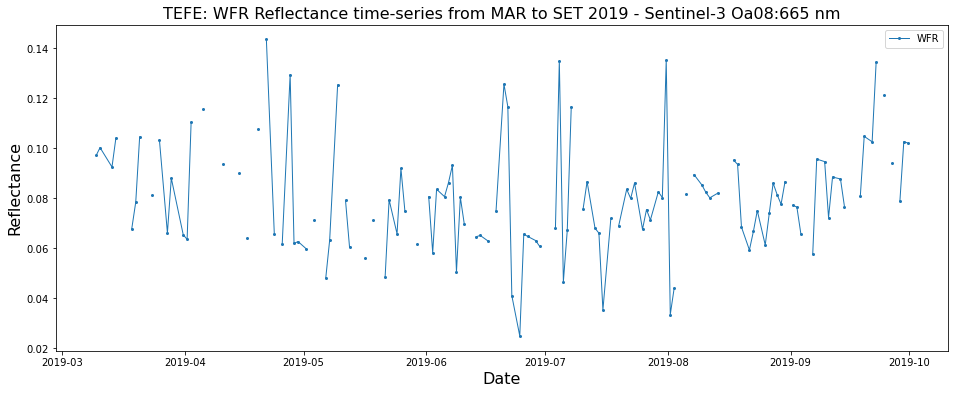

In [381]:
plt.rcParams['figure.figsize'] = [16, 6]
# fig = plt.figure()
ax = plt.axes()
ax.set_title('NEGRO: WFR Reflectance time-series from MAR to SET 2019 - Sentinel-3 Oa08:665 nm', fontsize=16)
# ax.set_ylim(0,0.2)

### iCOR
# ax.plot(df_coari_icor_m2['Datetime'], df_coari_icor_m2['B8-665'], marker='D', markersize=3, linewidth=0.5, label='iCOR')
# ax.plot(df_fonte_boa_icor_m['Datetime'], df_fonte_boa_icor_m['B8-665'], marker='o', markersize=2, linewidth=0.5, label='iCOR')
# ax.plot(df_madeira_icor_m['Datetime'], df_madeira_icor_m['B8-665'], marker='o', markersize=2, linewidth=0.5, label='iCOR')
# ax.plot(df_manacapuru_icor_m2['Datetime'], df_manacapuru_icor_m2['B8-665'], marker='o', markersize=2, linewidth=0.5, label='iCOR')
# ax.plot(df_negro_icor_m2['Datetime'], df_negro_icor_m2['B8-665'], marker='o', markersize=2, linewidth=0.5, label='iCOR')
# ax.plot(df_tefe_icor_m2['Datetime'], df_tefe_icor_m2['B8-665'], marker='o', markersize=2, linewidth=0.5, label='iCOR')

### WFR
# ax.plot(df_coari_wfr_m2['Datetime'], df_coari_wfr_m2['B8-665'], marker='s', markersize=3, linewidth=1, label='WFR')
# ax.plot(fonte_boa_dict['Datetime'], fonte_boa_dict['B8-665'], marker='o', markersize=2, linewidth=0.5, label='WFR')
# ax.plot(madeira_dict['Datetime'], madeira_dict['B8-665'], marker='o', markersize=2, linewidth=0.5, label='WFR')
# ax.plot(df_manacapuru_wfr_m2['Datetime'], df_manacapuru_wfr_m2['B8-665'], marker='o', markersize=2, linewidth=0.5, label='WFR')
ax.plot(df_negro_wfr_m2['Datetime'], df_negro_wfr_m2['B8-665'], marker='o', markersize=2, linewidth=1, label='WFR')
# ax.plot(df_tefe_wfr_m2['Datetime'], df_tefe_wfr_m2['B8-665'], marker='o', markersize=2, linewidth=1, label='WFR')

ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Reflectance', fontsize=16)
ax.legend()
# plt.savefig('D:\\processing\\win\\a1_plots\\manacapuru-icor-vs-wfr-match-b8-th02.png', dpi=300)
plt.show()

In [337]:
print(len(df_coari_icor_m2),
      len(df_fonte_boa_icor_m2),
      len(df_madeira_icor_m2),
      len(df_manaca_icor_m2),
      len(df_negro_icor_m2),
      len(df_tefe_icor_m2))

154 129 152 183 188 160


In [336]:
print(len(df_coari_wfr_m2),
      len(df_fonte_boa_wfr_m2),
      len(df_madeira_wfr_m2),
      len(df_manaca_wfr_m2),
      len(df_negro_wfr_m2),
      len(df_tefe_wfr_m2))

154 129 152 183 188 160


In [262]:
print(len(df_coari_wfr_m), len(df_coari_icor_m), len(coari_m))
print(len(df_fonte_boa_wfr_m), len(df_fonte_boa_icor_m), len(fonte_boa_m))

154 154 154
129 129 129


## Part III: Generating the scatterplots

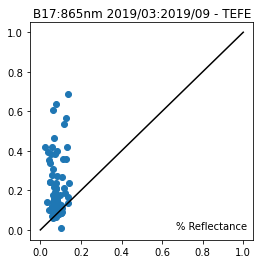

In [376]:
# plt.scatter(df_coari_wfr_match['B8-665'],df_coari_icor_match['B8-665'])
# plt.plot( [0,1],[0,1],'k-' )

# plt.rcParams['figure.figsize'] = [4, 4]
fig = plt.figure()
ax = plt.axes()
ax.set_title('B17:865nm 2019/03:2019/09 - TEFE')

# ax.scatter(df_coari_wfr_m2['B17-865'],df_coari_icor_m2['B17-865'])
# ax.scatter(df_fonte_boa_wfr_m2['B8-665'],df_fonte_boa_icor_m2['B8-665'])
# ax.scatter(df_madeira_wfr_m2['B8-665'],df_madeira_icor_m2['B8-665'])
# ax.scatter(df_manaca_wfr_m2['B8-665'],df_manaca_icor_m2['B8-665'])
# ax.scatter(df_negro_wfr_m2['B8-665'],df_negro_icor_m2['B8-665'])
ax.scatter(df_tefe_wfr_m2['B8-665'],df_tefe_icor_m2['B8-665'])

ax.plot( [0,1],[0,1],'k-' )
# ax.set_xlabel('WFR')
# ax.set_ylabel('iCOR')
# ax.set_xlim(0,0.2)
# ax.set_ylim(0,0.2)
# plt.text(0.132,0.006,'% Reflectance')
plt.text(0.67,0.006,'% Reflectance')
plt.savefig('D:\\processing\\win\\a1_plots\\tefe-icor-vs-wfr-sktr-b17.png', dpi=300)
plt.show()

# For further plotting it with annotations on each point:
# https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point

In [131]:
# Ok, the data looks incompatible because we dropped every row with reflectance > 0.16 in Oa08. So... Let's reprocess.

In [134]:
# Creating a list of .kml files
kml_path = 'D:\\A1_JM\\areas'
kmlareas = os.listdir(kml_path)
kmlareas = [os.path.join(kml_path,a) for a in kmlareas if a.endswith('.kml')]
kmlareas

['D:\\A1_JM\\areas\\coari.kml',
 'D:\\A1_JM\\areas\\fonte_boa.kml',
 'D:\\A1_JM\\areas\\madeira.kml',
 'D:\\A1_JM\\areas\\manacapuru.kml',
 'D:\\A1_JM\\areas\\negro.kml',
 'D:\\A1_JM\\areas\\tefe.kml']

In [136]:
outfolders = ["D:\\processing\\win\\COARI",
              "D:\\processing\\win\\FONTE_BOA",
              "D:\\processing\\win\\MADEIRA",
              "D:\\processing\\win\\MANACAPURU",
              "D:\\processing\\win\\NEGRO",
              "D:\\processing\\win\\TEFE"]

In [141]:
tsgen = TsGenerator()
t1 = time.perf_counter()

for n, r in enumerate(kmlareas):
    tsgen.netcdf_kml_slicer(gpt_path="C:\\Program Files\\snap\\bin\\gpt.exe",
                           kml_path=r,
                           input_imgs_folder="E:\\S3\\L2_WFR",
                           output_folder=outfolders[n])

t2 = time.perf_counter()
print(f'Finished in {round(t2 - t1, 2)} second(s).')

Finished in 8726.41 second(s).


In [169]:
output_files = ["D:\\processing\\win\\coari_wfr_ts.csv",
                "D:\\processing\\win\\fonte_boa_wfr_ts.csv",
                "D:\\processing\\win\\madeira_wfr_ts.csv",
                "D:\\processing\\win\\manacapuru_wfr_ts.csv",
                "D:\\processing\\win\\negro_wfr_ts.csv",
                "D:\\processing\\win\\tefe_wfr_ts.csv"]

In [160]:
t1 = time.perf_counter()


for n, fold in enumerate(outfolders):
    
    print('Working on region:',fold.split('\\')[-1])
    # Generates a python list using os.listdit sorted by date
    # PS1. The folder MUST contain text files generated using netcdf_kml_slicer 
    # from the TsGenerator class! 
    # PS2. Do not forget to delete the AUX folder of each image inside the output 
    # folders of each region.
    sorted_files = tsgen.build_list_from_subset(fold)
    
    print(f'Generating python dictionary from {len(sorted_files)} files inside:',fold)
    # Uses the sorted list to generate a dictionary containing the time-series
    ts_dict = tsgen.generate_time_series_data(fold, sorted_files)
    
    print('Saving dictionary as pandas DataFrame:',output_files[n])
    # Saves the dictionary as a pandas DataFrame
    tsgen.save_tms_to_csv(ts_dict, output_files[n])

t2 = time.perf_counter()
print(f'Finished in {round(t2 - t1, 2)} second(s).')

Working on region: COARI
Generating python dictionary from 311 files inside: D:\processing\win\COARI
Saving dictionary as pandas DataFrame: D:\processing\win\coari_wfr_ts.csv
Working on region: FONTE_BOA
Generating python dictionary from 246 files inside: D:\processing\win\FONTE_BOA
Saving dictionary as pandas DataFrame: D:\processing\win\fonte_boa_wfr_ts.csv
Working on region: MADEIRA
Generating python dictionary from 313 files inside: D:\processing\win\MADEIRA
Saving dictionary as pandas DataFrame: D:\processing\win\madeira_wfr_ts.csv
Working on region: MANACAPURU
Generating python dictionary from 370 files inside: D:\processing\win\MANACAPURU


C:\Users\david\.conda\envs\git-prj\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (59) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saving dictionary as pandas DataFrame: D:\processing\win\manacapuru_wfr_ts.csv
Working on region: NEGRO
Generating python dictionary from 369 files inside: D:\processing\win\NEGRO
Saving dictionary as pandas DataFrame: D:\processing\win\negro_wfr_ts.csv
Working on region: TEFE
Generating python dictionary from 304 files inside: D:\processing\win\TEFE
Saving dictionary as pandas DataFrame: D:\processing\win\tefe_wfr_ts.csv
Finished in 525.22 second(s).
